# Lab 01: Urbana Weather

---
author: Alejandra Arias
date: September 6, 2024
embed-resources: true
---

## Introduction

### Background

The Lincoln Square mall is located in Urbana where the Common Ground Food Co-Operative and the Market at the Sqaure (also known as the Urbana Farmers Market) is hosted! Due to the patterns of midwest weather, the market is only outdoors during reasonable weather but as winter approaches, some vendors wish to continue in Lincoln Square despite its restricting capacity.
### What this model is for
Each year around this time the market changes from indoors to outdoors so the purpose of this report is to reliably predict when to make the move well in advance to give vendors certainty about when the change will take place considering that not all vendors will switch to indoors. The hope is that the odel will deliver the minimum daily temperature as to predict if it will be too cold that day.

## Methods

In [1]:
# imports
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

### Data

In [2]:
# load data
weather_train = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-train.csv",
    index_col="date",
    parse_dates=True
)
weather_vtrain = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-vtrain.csv",
    index_col="date",
    parse_dates=True
)
weather_validation = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-validation.csv",
    index_col="date",
    parse_dates=True
)
weather_test = pd.read_csv(
    "https://cs307.org/lab-01/data/weather-test.csv",
    index_col="date",
    parse_dates=True
)
weather_train

,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2016-01-01,-4.2715,2016,1,1,1
2016-01-02,-3.8715,2016,1,2,2
2016-01-03,-4.4715,2016,1,3,3
2016-01-04,-3.0215,2016,1,4,4
2016-01-05,-5.7715,2016,1,5,5
...,...,...,...,...,...
2021-12-27,6.9980,2021,12,27,361
2021-12-28,1.7980,2021,12,28,362
2021-12-29,2.1980,2021,12,29,363


The data is being loaded and split into an x and y, for training, testing, and validation. For this report we will be looking at the training and testing data. There is about 2192 rows in the training dataset. 

In the information below we have summary statistics based on the years and months, we have the mean temperature, standard deviation, and count. The groupby function was used because its able to aggregate the dataset based off different categories such as mean, sum, count, median, etc. This makes it easier to calculate these statistics without needing huge lines of code. Because we are only focused on the temperature for the groupby, we filter out so it only displays that value.

In [4]:
month_mean = weather_train.groupby("month").agg("mean").reset_index()["temperature_2m_min"]
month_std = weather_train.groupby("month").agg("std").reset_index()["temperature_2m_min"]
month_count = weather_train.groupby("month").agg("count").reset_index()["temperature_2m_min"]
month_mean, month_std, month_count

(0     -4.999336
 1     -3.856209
 2      1.577277
 3      5.985861
 4     12.446632
 5     18.240583
 6     19.975933
 7     19.136954
 8     16.793083
 9     10.102277
 10     1.780861
 11    -2.210358
 Name: temperature_2m_min, dtype: float64,
 0     6.752006
 1     6.760570
 2     5.615212
 3     5.615279
 4     5.342291
 5     3.492687
 6     2.632969
 7     2.889118
 8     3.815779
 9     5.852142
 10    5.523113
 11    5.433891
 Name: temperature_2m_min, dtype: float64,
 0     186
 1     170
 2     186
 3     180
 4     186
 5     180
 6     186
 7     186
 8     180
 9     186
 10    180
 11    186
 Name: temperature_2m_min, dtype: int64)

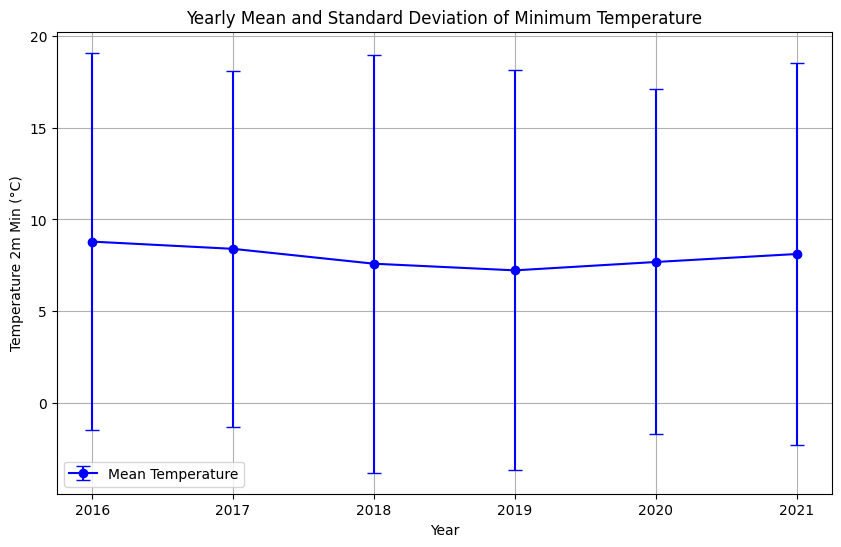

In [5]:
# visualizations
import matplotlib.pyplot as plt

years = weather_train.groupby("year").agg("mean").reset_index()["year"]

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(years, year_mean, yerr=year_std, fmt='-o', label="Mean Temperature", capsize=5, color="b")

plt.xlabel('Year')
plt.ylabel('Temperature 2m Min (°C)')
plt.title('Yearly Mean and Standard Deviation of Minimum Temperature')
plt.legend()
plt.grid(True)

plt.show()


In [3]:
import matplotlib.pyplot as plt

months = weather_train.groupby("month").agg("mean").reset_index()["month"]

plt.figure(figsize=(10, 6))
plt.errorbar(months, month_mean, yerr=month_std, fmt='-o', label="Mean Temperature", capsize=5, color="")

plt.xlabel('Month')
plt.ylabel('Temperature 2m Min (°C)')
plt.title('Monthly Mean and Standard Deviation of Minimum Temperature')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)

plt.show()


NameError: name 'month_mean' is not defined

<Figure size 1000x600 with 0 Axes>

The visuals here are called error bars which represent the standard deviation of the temperature for the year or month. This shows how spread out the mean temperatures are depending on the time of year. Longer bard indicate more variability while shorter bars suggest the data points are more clustered and close around the mean. The line is connecting the mean temperatures for each month. We can see that colder months such as Decemeber and January indicate a lot variation compared to july where the bars are shorter. The years appear to be more consistent where they all have some form of variation.

### Models

In [7]:
# process data for ML
# create X and y for train
X_train = weather_train[["year", "day_of_year"]]
y_train = weather_train["temperature_2m_min"]

# create X and y for validation-train
X_vtrain = weather_vtrain[["year", "day_of_year"]]
y_vtrain = weather_vtrain["temperature_2m_min"]

# create X and y for validation
X_validation = weather_validation[["year", "day_of_year"]]
y_validation = weather_validation["temperature_2m_min"]

# create X and y for test
X_test = weather_test[["year", "day_of_year"]]
y_test = weather_test["temperature_2m_min"]

In [8]:
# train models
import numpy as np
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def residuals(y_true, y_pred):
    return y_true - y_pred

max_rmse = 100000
k_val = -1
res = 100000
mod = KNeighborsRegressor(n_neighbors=1)
for i in range(1, 100, 1):
    modi = KNeighborsRegressor(n_neighbors=i)
    modi.fit(X_train, y_train)
    modi.predict(X_test)
    rmse_val = rmse(y_test, modi.predict(X_test))
    if rmse_val < max_rmse:
        max_rmse = rmse_val
        mod = modi 
        k_val = i
        res = residuals(y_test, modi.predict(X_test))

In [9]:
from joblib import dump
dump(mod, "urbana-weather.joblib")

['urbana-weather.joblib']

This model will be using ``K-Nearest Neighbors`` Algorithm, also known as KNN. This is because of not only its simplicity but because our weather data is non linear as seen in the visuals which makes KNN an excellent model for this data. As mentioned previously, for this model and report only the training and testing data will be used, not the validation. the function rmse returns the RMSE depending on the k value.

In order to find the best KNN model, a for loop was made where it ranges from KNN regression number 1 all the way to 100. Then the RMSE is found and if it is less than the max_rmse, the max now becomes the current model and rmse to save which is the best model. 

## Results

In [10]:
# report model metrics
print("Best k value: ", k_val)
print("Test RMSE for k: ", max_rmse)

Best k value:  92
Test RMSE for k:  5.122196580406948


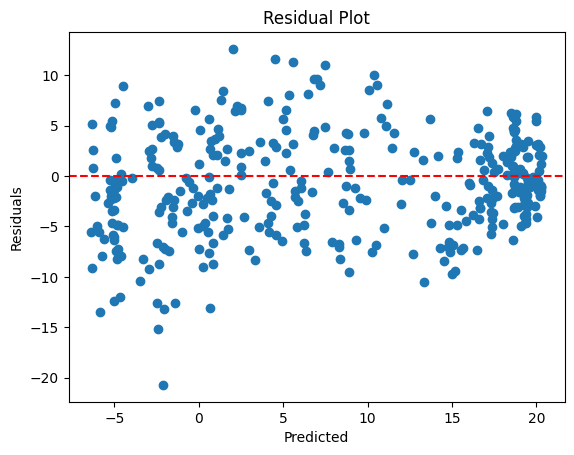

In [11]:
# residuals 
plt.scatter(mod.predict(X_test), res)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

According to our print statements, the best Test RMSE for k was 92 which got us an rmse of ~5.122. This is lower than our desired rmse which was 5.5! We can see that the residuals are pretty uniform so there's nothing as of yet that can indicate this is not a reliable way to predict temperature.

## Discussion

Because KNN relies on a distance metric to find the nearest data points, using it might not be the most optimized. This is because we are using months and years as features. The issue is that using a time to find neighbors are not exactly "spatial" and there might not be overwhelming distances to indicate clusters. 

Furthermore, The weather changes drastically depending on the day, considering Urbana, IL is in the midwest, it is possible to see very different weathers such as raining one day and 90 degress the next. August 1st may have completely different weather compared to August 30th so taking the mean into account might result in some problems. KNN is helpful here in the sense that this data is non linear, as mentioned previously, which works well for KNN models!

As per the splitting, in this report the data was not split in a traditional way, rather this data was given to use which may impact our results had we done a train test split. Per the results visual it doesnt seem that the data would have any major issues with outliers or overfitting which is something to consider when training any model.

### Conclusion

Although there are some flaws to this model, the KNN model passed the intial RMSE test which is a step in the right direction. There are a lot more things that can be covered in future reports such as more statistics to determine any outliers, the distribution of data, overfitting, variance, etc. All of these factors may indicate that a K-Nearest Neighbors model may not be the best but for an intial option it's something to consider. KNN is useful in this case because of our non-linear data and simplicity. Any more models might have been too much to include for something as small as weather considering our dataset was only ~2900 rows. Unpredictable weather in Urbana may make it difficult to rely on this model but it's a starting point for vendors and prospective customers to use! 